## Import libraries

In [1]:
import pathlib
import isthmuslib as isli
import json
from typing import List, Dict, Any
import pandas as pd

## Load data

In [2]:
transactions_file: pathlib.Path = pathlib.Path("/home/bird/Projects/GitHub/monero_fingerprinting_pipeline/DATA/transactions.feather")

txns: isli.VectorMultiset = isli.VectorMultiset().read_any(transactions_file, inplace=False)

## Feature extraction (flatten rings)

In [3]:
def flatten_ring_members(row):
    input_str: str = row["inputs"].replace("'", '"')
    inputs_data: List[Dict[str, Any]] = json.loads(input_str)
    flat_rings: List[int] = []
    for i_ in inputs_data:
        flat_rings.extend(i_["ring_member_indices"])
    row["flat_ring_members"] = flat_rings
    return row


print(f"... flatting across rings")
txns.data["flat_ring_members"] = None
txns.data = txns.data.apply(flatten_ring_members, axis=1)

print(f"... flattening across transactions")
all_indices: List[int] = []
for ring_member_list in txns.data["flat_ring_members"]:
    all_indices.extend(ring_member_list)

... flatting across rings
... flattening across transactions


## Count uses

In [4]:
series: pd.Series = pd.Series(all_indices)
value_counts = series.value_counts()
df = value_counts.reset_index()
df.columns = ["output_index", "use_count"]
df.sort_values(by="use_count", ascending=False, inplace=True)

## Review - tabular

In [5]:
df.head()

,output_index,use_count
0,36209202,318
1,36185669,318
2,36204221,317
3,36225639,317
4,36191296,317


## Review - viz

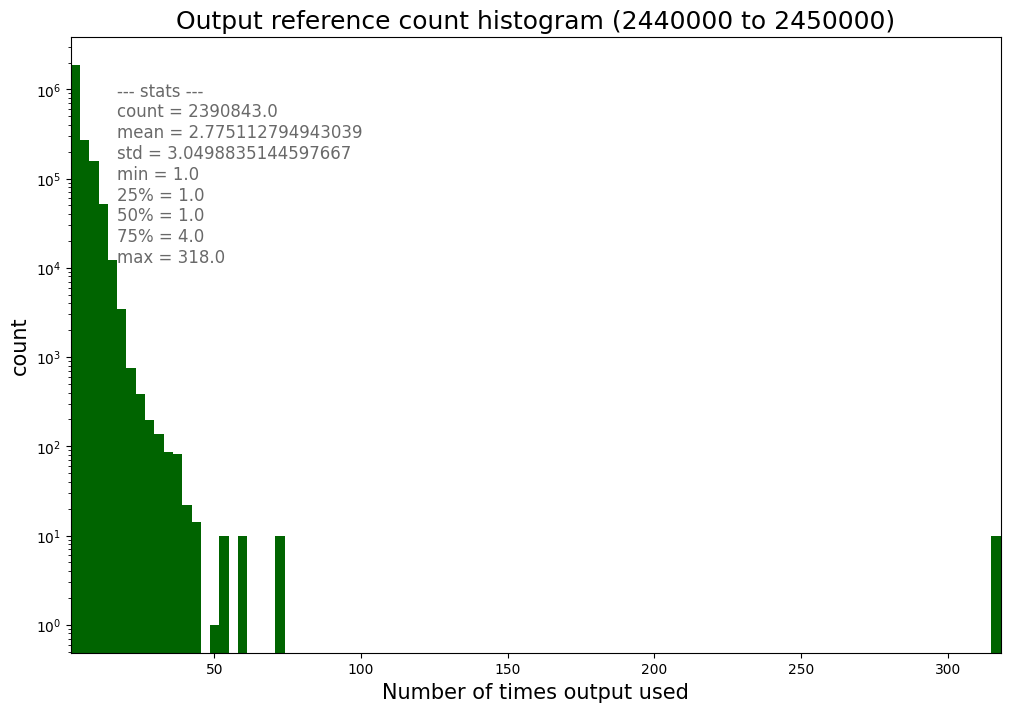

In [6]:
ring_range: str = f"{min(txns.data.block_height)} to {max(txns.data.block_height)}"
isli.hist(
    df["use_count"].tolist(),
    bins=100,
    log_axes="y",
    xlabel="Number of times output used",
    ylabel="count",
    title=f"Output reference count histogram ({ring_range})",
    describe=True,
    figsize=(12, 8),
);